**[Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting)**

# Preprocessing
* * * *

In [1]:
"""
Contributions from:
DSEverything - Mean Mix - Math, Geo, Harmonic (LB 0.493) 
https://www.kaggle.com/dongxu027/mean-mix-math-geo-harmonic-lb-0-493
JdPaletto - Surprised Yet? - Part2 - (LB: 0.503)
https://www.kaggle.com/jdpaletto/surprised-yet-part2-lb-0-503
hklee - weighted mean comparisons, LB 0.497, 1ST
https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st

Also all comments for changes, encouragement, and forked scripts rock

Keep the Surprise Going
"""

import glob, re
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime

data = {
    'tra': pd.read_csv('../../../mltestdata/05_recruit/air_visit_data.csv'),
    'as': pd.read_csv('../../../mltestdata/05_recruit/air_store_info.csv'),
    'hs': pd.read_csv('../../../mltestdata/05_recruit/hpg_store_info.csv'),
    'ar': pd.read_csv('../../../mltestdata/05_recruit/air_reserve.csv'),
    'hr': pd.read_csv('../../../mltestdata/05_recruit/hpg_reserve.csv'),
    'id': pd.read_csv('../../../mltestdata/05_recruit/store_id_relation.csv'),
    'tes': pd.read_csv('../../../mltestdata/05_recruit/sample_submission.csv'),
    'hol': pd.read_csv('../../../mltestdata/05_recruit/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

/Users/suzukiry/lab/March/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/suzukiry/lab/March/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/suzukiry/lab/March/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be remove

In [2]:
for df in ['ar','hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    tmp1 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})
    tmp2 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs2', 'reserve_visitors':'rv2'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])


In [3]:
sub_index = data['tes'].id

In [4]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

In [5]:
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

#sure it can be compressed...
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 
# NEW FEATURES FROM Georgii Vyshnia
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
lbl = preprocessing.LabelEncoder()

In [6]:
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 

train = pd.merge(train, stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])

for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2


In [7]:
# NEW FEATURES FROM JMBULL
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

# NEW FEATURES FROM Georgii Vyshnia
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
train = train.fillna(-1)
test = test.fillna(-1)

In [8]:
#drop_list = ['visit_date','id']
drop_list = ['id']
train_dropped = train.drop(drop_list,axis=1)
test_dropped = test.drop(drop_list,axis=1)

test_dropped = test_dropped.drop("visitors",axis=1)

In [9]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(train_dropped['air_store_id'])
train_dropped['air_store_id'] = le.fit_transform(train_dropped['air_store_id'])
test_dropped['air_store_id'] = le.fit_transform(test_dropped['air_store_id'])

In [10]:
X_train = train_dropped.drop(['visitors'], axis=1)
y_train = (train_dropped['visitors'].values)

In [11]:
X_train.columns

Index(['air_store_id', 'visit_date', 'dow', 'year', 'month', 'day_of_week',
       'holiday_flg', 'min_visitors', 'mean_visitors', 'median_visitors',
       'max_visitors', 'count_observations', 'air_genre_name', 'air_area_name',
       'latitude', 'longitude', 'air_genre_name0', 'air_area_name0',
       'air_genre_name1', 'air_area_name1', 'air_genre_name2',
       'air_area_name2', 'air_genre_name3', 'air_area_name3',
       'air_genre_name4', 'air_area_name4', 'air_genre_name5',
       'air_area_name5', 'air_genre_name6', 'air_area_name6',
       'air_genre_name7', 'air_area_name7', 'air_genre_name8',
       'air_area_name8', 'air_genre_name9', 'air_area_name9', 'rs1_x', 'rv1_x',
       'rs2_x', 'rv2_x', 'rs1_y', 'rv1_y', 'rs2_y', 'rv2_y',
       'total_reserv_sum', 'total_reserv_mean', 'total_reserv_dt_diff_mean',
       'date_int', 'var_max_lat', 'var_max_long', 'lon_plus_lat',
       'air_store_id2'],
      dtype='object')

In [12]:
df = train_dropped.drop(['air_store_id', 'dow', 'year', 'month', 'day_of_week',
                   'holiday_flg', 'min_visitors', 'mean_visitors', 'median_visitors',
                   'max_visitors', 'count_observations', 'air_genre_name', 'air_area_name',
                   'latitude', 'longitude', 'air_genre_name0', 'air_area_name0',
                   'air_genre_name1', 'air_area_name1', 'air_genre_name2',
                   'air_area_name2', 'air_genre_name3', 'air_area_name3',
                   'air_genre_name4', 'air_area_name4', 'air_genre_name5',
                   'air_area_name5', 'air_genre_name6', 'air_area_name6',
                   'air_genre_name7', 'air_area_name7', 'air_genre_name8',
                   'air_area_name8', 'air_genre_name9', 'air_area_name9', 'rs1_x', 'rv1_x',
                   'rs2_x', 'rv2_x', 'rs1_y', 'rv1_y', 'rs2_y', 'rv2_y',
                   'total_reserv_sum', 'total_reserv_mean', 'total_reserv_dt_diff_mean',
                   'date_int', 'var_max_lat', 'var_max_long', 'lon_plus_lat',
                   'air_store_id2'
                   ], axis=1)

In [13]:
test_df = test_dropped.drop(['air_store_id', 'dow', 'year', 'month', 'day_of_week',
                   'holiday_flg', 'min_visitors', 'mean_visitors', 'median_visitors',
                   'max_visitors', 'count_observations', 'air_genre_name', 'air_area_name',
                   'latitude', 'longitude', 'air_genre_name0', 'air_area_name0',
                   'air_genre_name1', 'air_area_name1', 'air_genre_name2',
                   'air_area_name2', 'air_genre_name3', 'air_area_name3',
                   'air_genre_name4', 'air_area_name4', 'air_genre_name5',
                   'air_area_name5', 'air_genre_name6', 'air_area_name6',
                   'air_genre_name7', 'air_area_name7', 'air_genre_name8',
                   'air_area_name8', 'air_genre_name9', 'air_area_name9', 'rs1_x', 'rv1_x',
                   'rs2_x', 'rv2_x', 'rs1_y', 'rv1_y', 'rs2_y', 'rv2_y',
                   'total_reserv_sum', 'total_reserv_mean', 'total_reserv_dt_diff_mean',
                   'date_int', 'var_max_lat', 'var_max_long', 'lon_plus_lat',
                   'air_store_id2'
                   ], axis=1)

In [14]:
df.head()

,visit_date,visitors
0,2016-01-13,25
1,2016-01-14,32
2,2016-01-15,29
3,2016-01-16,22
4,2016-01-18,6


In [15]:
df.tail()

,visit_date,visitors
252103,2017-04-18,6
252104,2017-04-19,6
252105,2017-04-20,7
252106,2017-04-21,8
252107,2017-04-22,5


In [16]:
test_df.head()

,visit_date
0,2017-04-23
1,2017-04-24
2,2017-04-25
3,2017-04-26
4,2017-04-27


# Data Exploring
* * * *

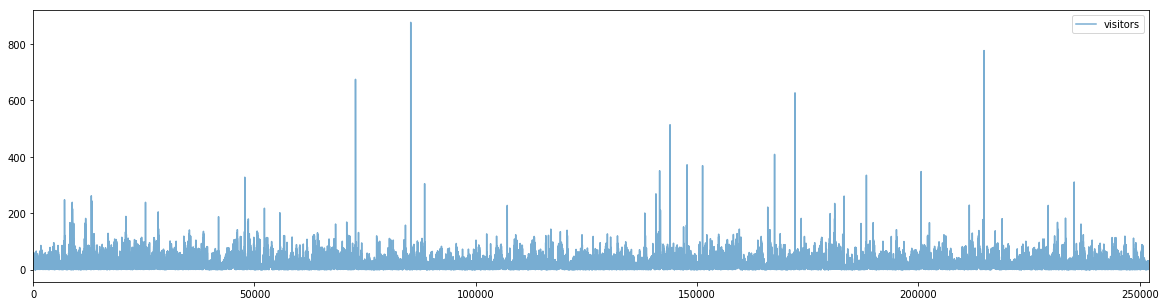

In [17]:
%matplotlib inline
df.plot(alpha=0.6, figsize=(20,5))

# Modeling
* * * * *

In [18]:
import tflearn

from sklearn.preprocessing import MinMaxScaler

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)


In [19]:
dataset = df.visitors.values
dataset = dataset.astype('float32')
dataset = dataset.reshape(-1,1)

dataset.shape

(252108, 1)

In [21]:
dataset[0]

array([ 25.], dtype=float32)

**正規化**

In [22]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [23]:
dataset[0]

array([ 0.02739726], dtype=float32)

** 訓練データとテストデータ **

In [77]:
def create_dataset(dataset, steps_of_history, steps_in_future):
    X, Y = [], []
    for i in range(0, len(dataset)-steps_of_history, steps_in_future):
        X.append(dataset[i:i+steps_of_history])
        Y.append(dataset[i + steps_of_history])
    X = np.reshape(np.array(X), [-1, steps_of_history, 1])
    Y = np.reshape(np.array(Y), [-1, 1])
    return X, Y

def split_data(x, y, test_size=0.1):
    pos = round(len(x) * (1 - test_size))
    trainX, trainY = x[:pos], y[:pos]
    testX, testY   = x[pos:], y[pos:]
    return trainX, trainY, testX, testY

steps_of_history = 1
#steps_of_history = 3

steps_in_future = 1
X, Y = create_dataset(dataset, steps_of_history, steps_in_future)
trainX, trainY, testX, testY = split_data(X, Y, 0.33)

In [78]:
print(str(trainX.shape)+' '+str(trainY.shape)+' '+str(testX.shape)+' '+str(testY.shape))

(168912, 1, 1) (168912, 1) (83195, 1, 1) (83195, 1)


In [79]:
print(str(trainX[0])+' '+str(trainY[0])+' '+str(testX[0])+' '+str(testY[0]))

[[ 0.02739726]] [ 0.03538813] [[ 0.00913242]] [ 0.01598174]


**TFLearnでLSTMネットワークを構築**

In [26]:
net = tflearn.input_data(shape=[None, steps_of_history, 1])

# LSTM
#net = tflearn.lstm(net, n_units=6)

# GRU
#net = tflearn.gru(net, n_units=6)

# GRU : Add one more layer
net = tflearn.gru(net, n_units=6, return_seq=True)
net = tflearn.gru(net, n_units=6)

net = tflearn.fully_connected(net, 1, activation='linear')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001,
        loss='mean_square')

model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(trainX, trainY, validation_set=0.1, batch_size=1, n_epoch=10)

Training Step: 1520199  | total loss: 0.00017 | time: 347.725s
| Adam | epoch: 010 | loss: 0.00017 -- iter: 152019/152020
Training Step: 1520200  | total loss: 0.00018 | time: 357.003s
| Adam | epoch: 010 | loss: 0.00018 | val_loss: 0.00033 -- iter: 152020/152020
--


In [80]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Validation
* * * * *

In [81]:
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

def RMSLE(y, pred):
    return mean_squared_error(y, pred)**0.5


# A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
# https://www.kaggle.com/marknagelberg/caterpillar-tube-pricing/rmsle-function
def rmsle(y, y_pred):
	assert len(y) == len(y_pred)
	terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
	return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5


In [82]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
#trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
#testY = scaler.inverse_transform([testY])

In [83]:
trainY = scaler.inverse_transform(trainY)
testY = scaler.inverse_transform(testY)

In [89]:
# calculate root mean squared Logarithmic error
#trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
trainScore = RMSLE(trainY[:,0], trainPredict[:,0])
print('Train Score: %.2f RMSLE' % (trainScore))
#testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
testScore = RMSLE(testY[:,0], testPredict[:,0])
print('Test Score: %.2f RMSLE' % (testScore))

Train Score: 14.62 RMSLE
Test Score: 13.56 RMSLE


# Submission
* * * 

In [95]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

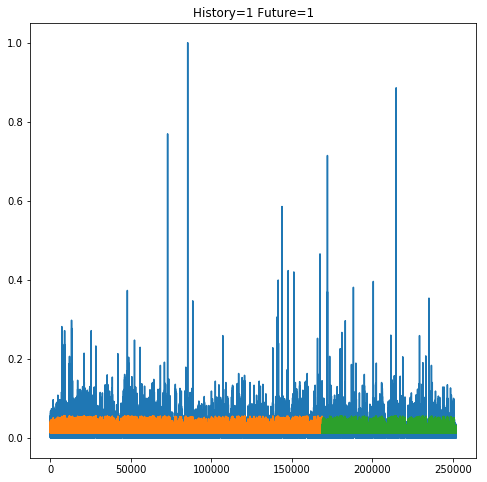

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline

train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[steps_of_history:len(train_predict)+steps_of_history, :] = \
        train_predict

test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+steps_of_history:len(dataset), :] = \
        test_predict

plt.figure(figsize=(8, 8))
plt.title('History={} Future={}'.format(steps_of_history, steps_in_future))
plt.plot(dataset)
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.savefig('passenger_gru1.png')

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

scores = cross_val_score(model, train, train_target, scoring = "neg_mean_squared_error",cv=5)
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

for i, score in enumerate(scores):
    print('Fold %4d: MSE= %s'% (i, score))
    
# Scoring types: http://scikit-learn.org/stable/modules/model_evaluation.html

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

scores = cross_val_score(gdm, train, train_target, scoring = "neg_mean_squared_error",cv=5)
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

for i, score in enumerate(scores):
    print('Fold %4d: MSE= %s'% (i, score))
    
# Scoring types: http://scikit-learn.org/stable/modules/model_evaluation.html

In [48]:
def rmse(y_pred, y_true):
    return np.sqrt(((y_true - y_pred) ** 2).mean())

def rmsle(y_pred, y_true):
    return np.sqrt(np.square(np.log(y_true + 1) - np.log(y_pred + 1)).mean())

def mae(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred)))

In [50]:
print('Train RMSE: %.5f' % rmse(train_predict,trainY))
print('Train RMSLE: %.5f' % rmsle(train_predict,trainY))
print('Train MAE: %.5f' % mae(train_predict,trainY))
print('_'*30)
print('Test RMSE: %.5f' % rmse(test_predict,testY))
print('Test RMSLE: %.5f' % rmsle(test_predict,testY))
print('Test MAE: %.5f' % mae(test_predict,testY))

Train RMSE: 0.01706
Train RMSLE: 0.01626
Train MAE: 0.01261
______________________________
Test RMSE: 0.01592
Test RMSLE: 0.01513
Test MAE: 0.01180


**Predict**

In [63]:
test_df.head()

,visit_date
0,2017-04-23
1,2017-04-24
2,2017-04-25
3,2017-04-26
4,2017-04-27


In [23]:
train_predict_plot = np.empty_like(dataset)

In [ ]:
train_predict_plot[:, :] = np.nan
train_predict_plot[steps_of_history:len(train_predict)+steps_of_history, :] = \
        train_predict

test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+steps_of_history:len(dataset), :] = \
        test_predict

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [ ]:
# =================================================
# model_selection.GridSearchCV
# =================================================
# 1) xgboostモデルの作成
reg = xgb.XGBRegressor()

# 2) XGBoost params

#XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
#       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
#       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
#       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
#       silent=True, subsample=1)

xgb_params = {
    'objective' : ['reg:gamma','reg:linear'], 
    'learning_rate' : [0.09,0.1],
    'n_estimators' : [80,100,120],
    'max_depth' : [3,4,5],
    'subsample' : [0.9,1],
    'colsample_bytree' : [0.9,1.0],
    'min_child_weight' : [0.9,1]
}

# 3) Run GridSearch
grid_xgb = GridSearchCV(reg,xgb_params,scoring='neg_mean_squared_error',cv=5,n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train)

# 4) Show best Params and Score
print("_"*30)
print("Result of Gridsearch")
print("Best params: ", grid_xgb.best_params_)
print("Best Estimator: ", grid_xgb.best_estimator_)
print("MSE: ", grid_xgb.best_score_)

# 5) Learning with best params
xgr_g = xgb.XGBRegressor(**grid_xgb.best_params_)
xgr_g.fit(X_train, y_train)
y_pred_gs = xgr_g.predict(X_test)

# 6) The error metric: RMSE
print("_"*30)
print("vs Prediction")
print("RMSE from local train: ", rmse(y_test, y_pred_gs))
print("MSE from local train: ", mean_squared_error(y_test, y_pred_gs))
print("R2 from local train: ", r2_score(y_test, y_pred_gs))

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 57.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 193.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 639.7min


In [72]:
predictions = xgr_g.predict(test_dropped)

In [73]:
sub = pd.DataFrame({"id": sub_index, "visitors": predictions})
sub.to_csv('submission_recruit_02Jan18_v01.csv', index=False)

In [74]:
sub_csv = pd.read_csv('./rs_submission_01Jan18_v04.csv')

In [75]:
sub_csv.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,3.133897
1,air_00a91d42b08b08d9_2017-04-24,21.227549
2,air_00a91d42b08b08d9_2017-04-25,23.996819
3,air_00a91d42b08b08d9_2017-04-26,28.515388
4,air_00a91d42b08b08d9_2017-04-27,30.262386


In [ ]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5
    
model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3)
model2 = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)
model1.fit(train[col], np.log1p(train['visitors'].values))
model2.fit(train[col], np.log1p(train['visitors'].values))
print('RMSE GradientBoostingRegressor: ', RMSLE(np.log1p(train['visitors'].values), model1.predict(train[col])))
print('RMSE KNeighborsRegressor: ', RMSLE(np.log1p(train['visitors'].values), model2.predict(train[col])))
test['visitors'] = (model1.predict(test[col]) + model2.predict(test[col])) / 2
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
sub1 = test[['id','visitors']].copy()
del train; del data;


In [6]:
# from hklee
# https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st/code
dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):
    pd.read_csv(fn)for fn in glob.glob('../../../mltestdata/05_recruit/*.csv')}

for k, v in dfs.items(): locals()[k] = v

wkend_holidays = date_info.apply(
    (lambda x:(x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1), axis=1)
date_info.loc[wkend_holidays, 'holiday_flg'] = 0
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5  

visit_data = air_visit_data.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')
visit_data.drop('calendar_date', axis=1, inplace=True)
visit_data['visitors'] = visit_data.visitors.map(pd.np.log1p)

wmean = lambda x:( (x.weight * x.visitors).sum() / x.weight.sum() )
visitors = visit_data.groupby(['air_store_id', 'day_of_week', 'holiday_flg']).apply(wmean).reset_index()
visitors.rename(columns={0:'visitors'}, inplace=True) # cumbersome, should be better ways.

sample_submission['air_store_id'] = sample_submission.id.map(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['calendar_date'] = sample_submission.id.map(lambda x: x.split('_')[2])
sample_submission.drop('visitors', axis=1, inplace=True)
sample_submission = sample_submission.merge(date_info, on='calendar_date', how='left')
sample_submission = sample_submission.merge(visitors, on=[
    'air_store_id', 'day_of_week', 'holiday_flg'], how='left')

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
    visitors[visitors.holiday_flg==0], on=('air_store_id', 'day_of_week'), 
    how='left')['visitors_y'].values

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
    visitors[['air_store_id', 'visitors']].groupby('air_store_id').mean().reset_index(), 
    on='air_store_id', how='left')['visitors_y'].values

sample_submission['visitors'] = sample_submission.visitors.map(pd.np.expm1)
sub2 = sample_submission[['id', 'visitors']].copy()
sub_merge = pd.merge(sub1, sub2, on='id', how='inner')

sub_merge['visitors'] = (sub_merge['visitors_x'] + sub_merge['visitors_y']* 1.1)/2
sub_merge[['id', 'visitors']].to_csv('submission.csv', index=False)

In [7]:
sub_merge.head()

,id,visitors_x,visitors_y,visitors
0,air_00a91d42b08b08d9_2017-04-23,2.555948,2.000000,2.377974
1,air_00a91d42b08b08d9_2017-04-24,20.944645,23.621632,23.464220
2,air_00a91d42b08b08d9_2017-04-25,25.206066,26.823130,27.355755
3,air_00a91d42b08b08d9_2017-04-26,27.570890,27.600920,28.965951
4,air_00a91d42b08b08d9_2017-04-27,31.519827,31.299646,32.974719
